In [6]:
# !pip show statsmodels
# !pip install --upgrade statsmodels

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd

asset = "BTC-USD"

# Period of test data (TODO: Change the period)
start_date = "2023-01-01"
end_date = "2025-01-01"

# Daily data of BTC-USD is used 

# auto_adjust=True is applied by default. 
# So,'Close' price is used instead of 'Adj Close'
df = yf.download(asset, start=start_date, end=end_date, interval='1d')['Close']
df.columns = ['Close']
df["Ret"] = df["Close"].pct_change()

# del df["Close"]
df = df.dropna()
df.head()

[*********************100%***********************]  1 of 1 completed


,Close,Ret
Date,,
2023-01-02,16688.470703,0.003813
2023-01-03,16679.857422,-0.000516
2023-01-04,16863.238281,0.010994
2023-01-05,16836.736328,-0.001572
2023-01-06,16951.968750,0.006844


In [8]:
import itertools
from hyperopt import hp, tpe, rand, fmin, Trials, STATUS_OK
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


class Metric:
    MAE = 0
    MSE = 1

class WeightingMethod:
    Inverted = 0
    SquaredInverted = 1
    Softmax = 2

class DefaultHP:
    lookback_window_size = 10
    metric = Metric.MAE
    weighting_method = WeightingMethod.Inverted
    discount_factor = 1.0  # no discounting
    smoothing_factor = 0.0  # no smoothing


def compute_comp_weights(hp_dict, y_truth, comp_preds, prev_comp_weights):
    lookback_window_size = int(hp_dict['lookback_window_size']) if 'lookback_window_size' in hp_dict else DefaultHP.lookback_window_size
    metric = hp_dict['metric'] if 'metric' in hp_dict else DefaultHP.metric
    weighting_method = hp_dict['weighting_method'] if 'weighting_method' in hp_dict else DefaultHP.weighting_method
    discount_factor = hp_dict['discount_factor'] if 'discount_factor' in hp_dict else DefaultHP.discount_factor
    smoothing_factor = hp_dict['smoothing_factor'] if 'smoothing_factor' in hp_dict else DefaultHP.smoothing_factor

    num_all_components = comp_preds.shape[0]
    if 'max_components' in hp_dict: 
        max_components = min(int(hp_dict['max_components']), num_all_components)
    else:
        max_components = num_all_components

    # TODO ! 
    # cool_start = int(hp_dict['cool_start'])

    # comp_errors_window.shape : [num_component_models, lookback_window_size]
    y_truth = np.tile(y_truth, (num_all_components,1)) 
    comp_errors_window = np.abs(comp_preds - y_truth)[:, -lookback_window_size:]

    # apply discounting to error_matrix, and compute the component_error
    tau = lookback_window_size # NOTE : Do we need to separate tau and lookback_window_size?
    try:
        discount = np.power(discount_factor, np.arange(1,tau+1))
        discounted_comp_error_window = np.multiply(comp_errors_window, discount)
    except:
        print("Error in discounting!")
        assert False
        # discounted_comp_error_window = comp_errors_window

    if metric == Metric.MSE:
        comp_errors = np.mean(np.power(discounted_comp_error_window,2), axis=1)
    else: # metric == Metric.MAE:
        comp_errors = np.mean(discounted_comp_error_window, axis=1)

    comp_errors = np.array([1e-5 if i<1e-12 else i for i in comp_errors])

    # compute the weights of component models by applying the weighting method
    if weighting_method == WeightingMethod.Softmax:
        if np.sum(np.exp(-comp_errors)) <1e-10:
            comp_errors = comp_errors / np.min(comp_errors)
        comp_weights = np.exp(-comp_errors) / np.sum(np.exp(-comp_errors))
    elif weighting_method == WeightingMethod.Inverted:
        comp_weights = np.power(comp_errors,-1) / np.sum(np.power(np.abs(comp_errors),-1))
    else: # weighting_method == WeightingMethod.SquaredInverted':
        comp_weights = np.power(comp_errors,-2) / np.sum(np.power(comp_errors,-2))

    # NOTE : Necesssary? 
    comp_weights = np.nan_to_num(comp_weights) 
    comp_weights = comp_weights / np.sum(comp_weights)
    assert np.linalg.norm(np.sum(comp_weights) - 1.0) < 1e-3   

    # smoothing the weights
    if prev_comp_weights is not None:
        comp_weights = smoothing_factor * prev_comp_weights + (1-smoothing_factor) * comp_weights

    # apply max_components constraint : choose max_components components with the highest weights
    if max_components < num_all_components:
        chosen_indices = np.argpartition(comp_weights, -max_components)[-max_components:] 
        comp_weights = np.array([comp_weights[i] if i in chosen_indices else 0 for i in range(num_all_components)])
        comp_weights = comp_weights / np.sum(comp_weights)

    return comp_weights


# class for Hyper-Parameter Optimization
class HPO(object):
    
    def __init__(self, y, comp_preds, use_BOA=True):
        self.y = y  # ground truth of forecast 
        self.comp_preds = comp_preds # predictions of component models
        self.use_BOA = use_BOA

    def optimize_HP(self, max_evals):
        num_comps = self.comp_preds.shape[0]
        space = {
            # 'cool_start': hp.quniform('cool_start', 0, num_comps-1, 1),
            'lookback_window_size': hp.quniform('lookback_window_size', 1, 13, 1),
            # 'max_components': hp.quniform('max_components', 1, num_comps, 1),
            'metric': hp.choice('metric', [Metric.MAE, Metric.MSE]),
            'weighting_method': hp.choice('weighting_method', 
                                          [WeightingMethod.Inverted, WeightingMethod.SquaredInverted, WeightingMethod.Softmax]),
            'discount_factor':hp.uniform('discount_factor', 1.0, 1.5),
            'smoothing_factor': hp.uniform('smoothing_factor', 0.0, 1),
        }

        trials = Trials()
        algo = tpe.suggest if self.use_BOA else rand.suggest
        # algo = partial(algo, n_startup_jobs=1) 
        best_hp = fmin(self._evaluate_hp, space, algo=algo, max_evals=max_evals, 
                       trials=trials, rstate=np.random.default_rng(1), verbose=True)
        return best_hp, trials


    # Objective function (loss function) for hyper-parameter optimization
    # Loss == Mean of the lossees in all timesteps in the period [lookback_window_size, len(y)]
    def _evaluate_hp(self, hp_dict):
        losses = []
        lookback_window_size = int(hp_dict['lookback_window_size'])
        comp_weights = None
        t = lookback_window_size
        while t < len(self.y):
            comp_weights = compute_comp_weights(
                hp_dict,
                self.y[t-lookback_window_size:t], 
                self.comp_preds[:, t-lookback_window_size: t], 
                comp_weights)
            next_y_hat = np.dot(comp_weights, self.comp_preds[:, t:t+1])
            next_y = self.y[t]
            losses.append(np.abs(next_y_hat - next_y))
            t += 1

        mean_loss = np.mean(losses)
        var_loss = np.var(losses)

        return {
            # TODO : add comp_weights 
            'loss': mean_loss,         
            'loss_variance': var_loss, 
            'status': STATUS_OK
        }


In [9]:

def show_hpo_result(HP, trials, title):
    print("\nHyperparameters:")
    hp_df = pd.DataFrame(HP, index=[0])
    print(hp_df)

    # Plot the optimization progress (loss and loss variance) 
    losses = [t['result']['loss'] for t in trials]           
    variances = [t['result']['loss_variance'] for t in trials]

    plt.figure(figsize=(8, 5))
    plt.plot(losses, marker='o', label='Mean Loss')
    plt.plot(variances, marker='x', label='Loss Variance')
    if title:
        plt.title(title)
    plt.xlabel("Trial Number")
    plt.ylabel("Value")
    plt.legend()    
    plt.grid(True)
    plt.show()


def plot_multiple_trials(trials_list, trial_labels, value_key, title=None):
    plt.figure(figsize=(8, 5))
    for i, trials in enumerate(trials_list):
        values = [t['result'][value_key] for t in trials] 
        plt.plot(values, marker='o', label=trial_labels[i])
    if title:
        plt.title(title)
    plt.xlabel("Trial Number")
    plt.ylabel(value_key)
    plt.legend()    
    plt.grid(True)
    plt.show()


def plot_forecast(y, y_hat, title=None):
    plt.figure(figsize=(8, 5))
    df = pd.DataFrame({
        'Ground Truth': y,
        'Forecast': y_hat
    })
    # plt.plot(df)
    df.plot()
    if title:
        plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()    
    plt.grid(True)
    plt.show()


def plot_weights(weights_hist, title=None):
    plt.figure(figsize=(8, 5))
    for i in range(weights_hist.shape[1]):
        plt.plot(weights_hist[:,i], label=f'Component {i}')
    if title:
        plt.title(title)
    plt.ylim(0, 1)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()    
    plt.grid(True)
    plt.show()


# validate the hyperparameters by forecasting in the period [lookback_window_size, len(y)]
def validate_enesemble_model(y, comp_preds, hp_dict):
    lookback_window_size = int(hp_dict['lookback_window_size'])
    y_hat = np.empty_like(y)
    weights_hist = np.empty((len(y)-lookback_window_size, comp_preds.shape[0]))

    comp_weights = None
    t = lookback_window_size
    while t < len(y):
        comp_weights = compute_comp_weights(
            hp_dict,
            y[t-lookback_window_size:t], 
            comp_preds[:, t-lookback_window_size: t], 
            comp_weights)
        y_hat[t] = np.dot(comp_weights, comp_preds[:, t:t+1])
        weights_hist[t-lookback_window_size] = comp_weights
        t += 1

    losses = np.abs(y[lookback_window_size:] - y_hat[lookback_window_size:])

    print("\nValidation Result (Loss)")
    print(f"max={np.max(losses)}, mean={np.mean(losses)}, min={np.min(losses)}, var={np.var(losses)})")
    plot_forecast(y[lookback_window_size:], y_hat[lookback_window_size:], title="Ensemble Forecast")
    plot_weights(weights_hist, title="Component Weights")



100%|██████████| 200/200 [00:03<00:00, 55.14trial/s, best loss: 0.021397042069390516]

Hyperparameters:
   discount_factor  lookback_window_size  metric  smoothing_factor  \
0         1.279897                   2.0       0          0.998113   

   weighting_method  
0                 1  


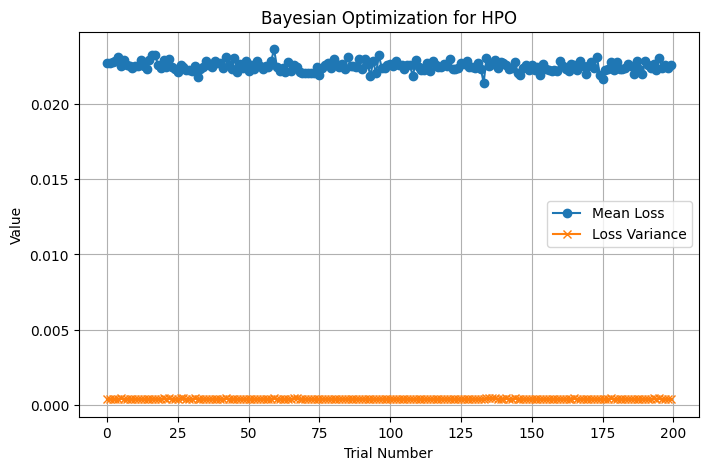

100%|██████████| 200/200 [00:03<00:00, 64.34trial/s, best loss: 0.021969544694084964]

Hyperparameters:
   discount_factor  lookback_window_size  metric  smoothing_factor  \
0         1.331052                   3.0       1          0.906383   

   weighting_method  
0                 1  


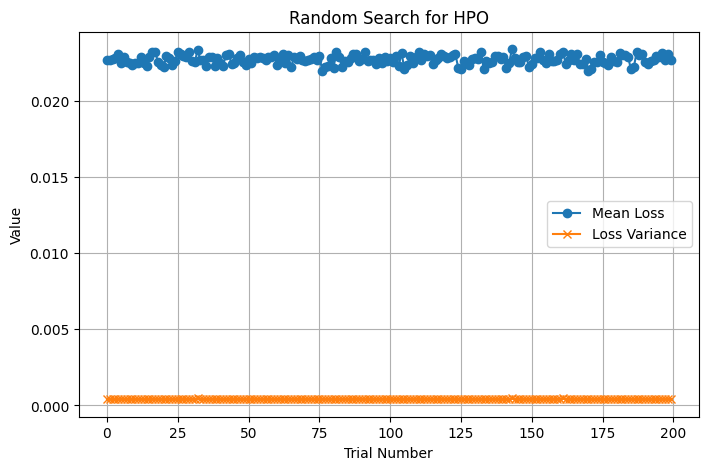


Validation Result (Loss)
max=0.1117001265569162, mean=0.02139040016622749, min=0.00011494776669982928, var=0.00031849031820067224)


<Figure size 800x500 with 0 Axes>

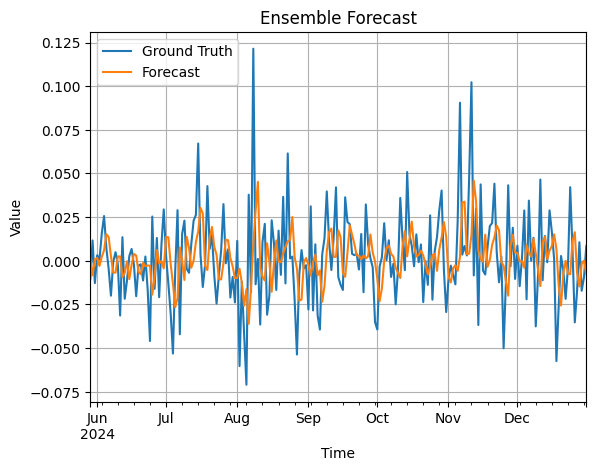

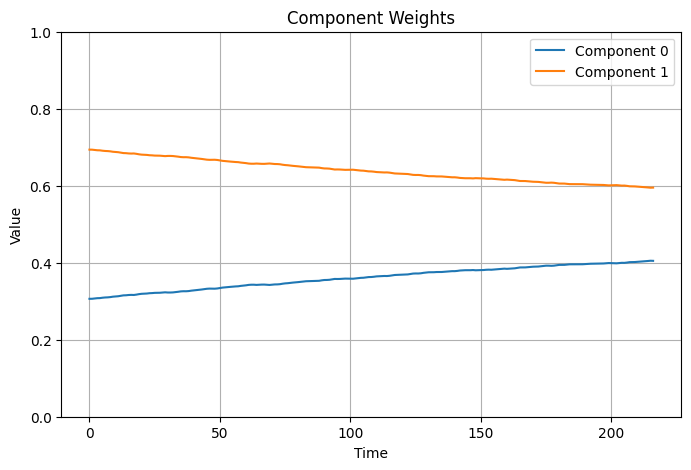


Validation Result (Loss)
max=0.11424608816587736, mean=0.020112603941502872, min=0.00011665920457170059, var=0.00030948147663139637)


<Figure size 800x500 with 0 Axes>

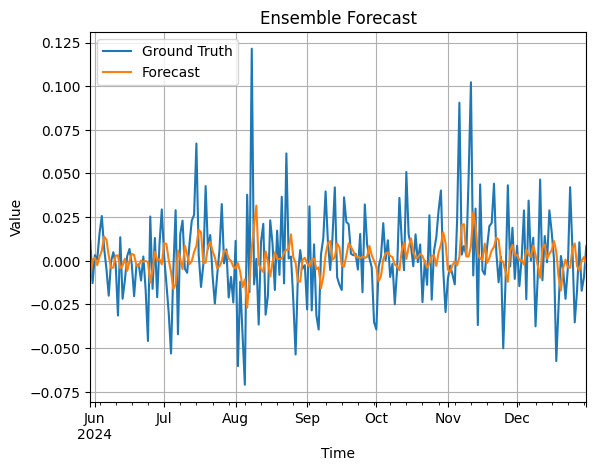

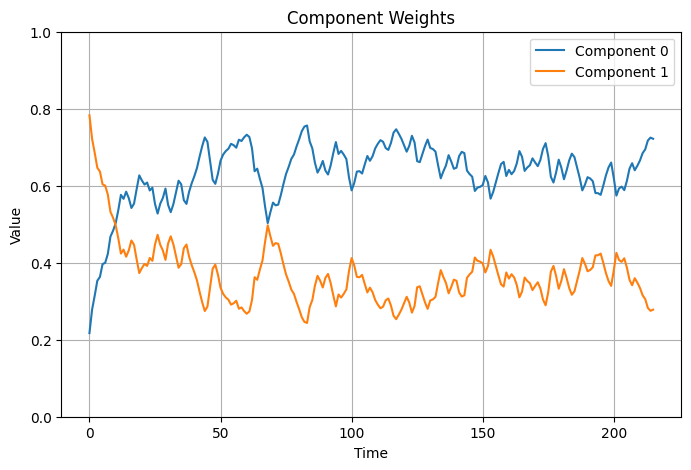

In [10]:


from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
from statsmodels.tsa.statespace.sarimax import SARIMAX

ts_all = df['Ret']
len_timeseries = len(ts_all)
assert len_timeseries >= 100, "The length of time series should be at least 100."

# We assume that component models of ensemble are already trained/validated. 
# Train and validating peroid for ensemble parameter is actually in test period for component models.
len_component_train = int(0.4 * len_timeseries) # period for training (and validating) component models
len_ensem_train = int(0.3 * len_timeseries) # period for trainig ensemble parmeters 
len_ensem_val = int(0.3 * len_timeseries)   # period for validating ensemble parmeters 
# period for testing ensemble forecast
len_ensem_test = len_timeseries - (len_component_train + len_ensem_train + len_ensem_val) 


# -----------------------------------
#  Train & Validate Component Models
# -----------------------------------

# number of component models to be included in ensemble
num_component_models = 2 

# train the component models with timeseries data in the period [0 ~ len_component_train+t]
model_ets = ETS(ts_all[:len_component_train], freq='D', trend="add", damped_trend=True, use_boxcox=False).fit()
model_sarima = SARIMAX(ts_all[:len_component_train], freq='D', trend='ct', order=(1,1,0), enforce_stationarity=False).fit(disp=False)

# (Validation of component models is skipped.)

# -----------------------------------
#  Train Ensemble Model
# -----------------------------------

# For ensemble training, prepare the forecasted values of component models in ensemble training period
comp_fcst = np.empty((num_component_models, len_ensem_train))
for t in range(len_ensem_train):
    if t > 0:
        # train the component models with timeseries data in the period [0 ~ len_component_train+t]
        # TODO : For statistial models, we don't have to feed all TS data. 
        # The TS data in the last 'lookback' (or input) window would be enough. 
        model_ets = ETS(ts_all[t:len_component_train+t], freq='D', trend="add", damped_trend=True, use_boxcox=False).fit()
        model_sarima = SARIMAX(ts_all[t:len_component_train+t], freq='D', trend='ct', order=(1,1,0), enforce_stationarity=False).fit(disp=False)
    # forecast next 'y' value
    comp_fcst[0,t] = model_ets.forecast(steps=1)
    comp_fcst[1,t] = model_sarima.forecast(steps=1)

# ground truth of ensemble forecast in ensemble training period
y_ensem_train = ts_all[len_component_train : len_component_train + len_ensem_train] 

# BOA 
model = HPO(y=y_ensem_train, comp_preds=comp_fcst, use_BOA=True)
hp_boa, trials_boa = model.optimize_HP(max_evals=200)
show_hpo_result(hp_boa, trials_boa, "Bayesian Optimization for HPO")

# Random Search
model = HPO(y=y_ensem_train, comp_preds=comp_fcst, use_BOA=False)
hp_rs, trials_rs = model.optimize_HP(max_evals=200)
show_hpo_result(hp_rs, trials_rs, "Random Search for HPO")


# -----------------------------------
#  Validate Ensemble model
# -----------------------------------

# ground truth of ensemble forecast in ensemble validating period
val_begin = len_component_train + len_ensem_train
y_ensem_val = ts_all[val_begin : val_begin + len_ensem_val] 

# For ensemble validation, prepare the forecasted values of component models in ensemble validation period
comp_fcst = np.empty((num_component_models, len_ensem_val))
for t in range(len_ensem_val):
    if t > 0:
        # train the component models with timeseries data in the period [0 ~ len_ensem_val+t]
        # TODO : For statistial models, we don't have to feed all TS data. 
        # The TS data in the last 'lookback' window would be enough. 
        model_ets = ETS(ts_all[val_begin - len_component_train + t : val_begin + t], 
                        freq='D', trend="add", damped_trend=True, use_boxcox=False).fit()
        model_sarima = SARIMAX(ts_all[val_begin - len_component_train + t : val_begin + t], 
                        freq='D', trend='ct', order=(1,1,0), enforce_stationarity=False).fit(disp=False)
    # forecast next 'y' value
    comp_fcst[0,t] = model_ets.forecast(steps=1)
    comp_fcst[1,t] = model_sarima.forecast(steps=1)

validate_enesemble_model(y_ensem_val, comp_fcst, hp_boa)
validate_enesemble_model(y_ensem_val, comp_fcst, hp_rs)

